# Tinder para empresas

## Imports

In [1]:
# Imports
import numpy as np
import pandas as pd
from scipy.spatial import distance
from random import choice
from beautifultable import BeautifulTable


# from translate_csv_functions import translate_csv

# from sklearn.preprocessing import MinMaxScaler
# pip3 install pandas ipython jupyter

## Preprocesado csv de las encuestas UX/UI


Descargar como CSV cada uno de los archivos de las respuestas en la carpeta ```./encuestas``` con el nombre por defecto que proporciona google: 
```
Student Form: 
https://docs.google.com/forms/d/17uP0aTeXo7gHRau3W5--CA4-vYjA1ur5eX2L8D25_xk/edit?ts=5cb08207

Company Form: 
https://docs.google.com/forms/d/1JpKsGgOfVaLiKg0uXTLb-Xp8TjG6k4KRz07pFd_GHuE/edit?ts=5cb07555

```

## Actual Madrid UX/UI
```

```

### 1. Companies

In [11]:
# Funciones translate CSV

DIC_COMPANIES = {
    "What is the name of your company?": "name", 
    'Does your company have specific language requirements for this position? [English]': 'english', 
    'Does your company have specific language requirements for this position? [Spanish]': 'spanish', 
    'Does your company have specific language requirements for this position? [Portuguese]': 'portuguese', 
    'Does your company have specific language requirements for this position? [French]': 'french', 
    'Does your company have specific language requirements for this position? [Dutch]': 'dutch', 
    'Does your company have specific language requirements for this position? [Catalan]': 'catalan', 
    'Where will this position be located?': 'location', 
    'Regarding remote working, how many days a week could the employee work off site?': 'offsite', 
    'On a scale from 1 to 10, how much time will the employee be spending working on back end and front end?': 'position', 
    
    # problema gordo, hay que hacer dummies ya que los excel no son similares
    '''
    hola sonia. Malas noticias.
Para UX/UI no se puede hacer el matching en un momento ya que los excel de empresas y estudiantes no son compatibles directamente.
Para que veas a lo que me refiero:

- En UX COMPANIES en la columna K pide que se seleccionen 3 aptitudes y aparecen separadas esas 3 por comas como por ejemplo: User research, Usability Testing, Interaction design

- En STUDENTS UX APR 2019 en la columna K, aunque el enunciado mencione 3 aptitudes, marca el nivel que tiene en cada una de la lista desde la columna K ([User research]) hasta la columna R ([Motion design])

Se podría arreglar la compatibilidad pero no en una mañana. Hay que expandir la columna K de companies en tantas como de K a R.

Siento decirte que no puedo hacer el match para UX/UI.
'''
    
    
    
    'From this list, please rank these 3 soft skills in order of importance for this position [Motivation and ability to overcome problems: employee has a passionate, can-do attitude and proactively looks for solutions to every problem they encounter]': 'motivation',
    'From this list, please rank these 3 soft skills in order of importance for this position [Coachability: Employee is receptive and actively listens and acts on feedback received]': 'coachability',
    'From this list, please rank these 3 soft skills in order of importance for this position [Teamwork: Employee is able to receive and provide value in a team environment]': 'teamwork' # El \r del final es para que sirva de terminador
    }

LANGUAGES = ['english', 'spanish', 'portuguese', 'french', 'dutch', 'catalan']

# hardskills en función de UXUI
HARDSKILLS = ['user', 'methodologies', 'usability', 'information', 'interaction', 'visual', 
              'html', 'motion']


def translate_language(x): 
    DIC_RESP_LANGUAGE = {
        # Company
        "No need": 1, 
        "Must be able to read basic documentation": 2, 
        "Must be able to read documentation and have an informal conversation": 3, 
        "Must be able to read documentation and communicate in a meeting": 4, 
        "Can work in full capacity in this language": 5, 
        # Students same
        "No Experience": 1, 
        "I'm able to read basic documentation": 2, 
        "I'm able to read documentation and have an informal conversation": 3, 
        "Able to read documentation and communicate in a meeting": 4, 
        "Can work in full capacity in this language": 5
    }
    # return 0 if x not in DIC_RESP_LANGUAGE.keys() else DIC_RESP_LANGUAGE[x] 
    return DIC_RESP_LANGUAGE.get(x, 0) # 0 default

def translate_location(x): 
    DIC_RESP_LOCATION = {
        # Company
        "In the city where the campus is located": 1, 
        "In the country where the campus is located": 2, 
        "In a city in another country": 3, 
        # Student
        "In the city where the campus is located": 1, 
        "Anywhere in the country where the campus is located": 2, 
        "Anywhere in the world": 3
    }
    # return 0 if x not in DIC_RESP_LOCATION.keys() else DIC_RESP_LOCATION[x] 
    return DIC_RESP_LOCATION.get(x, 0) # 0 default


def translate_offsite(x): 
    DIC_RESP_OFFSITE = {
        # Company
        "100% office-based job. We're not keen on remote working.": 1, 
        "1-2 Days a week": 2, 
        "3+ Days. It's up to the employee": 3, 
        "100% remote-based job. No physical office.": 4, 
        # Student
        "100% office-based job.": 1, 
        "1-2 Days a week": 2, 
        "3+ Days": 3, 
        "100% remote-based job. No physical office.": 4
    }
    # return 0 if x not in DIC_RESP_OFFSITE.keys() else DIC_RESP_OFFSITE[x] 
    return DIC_RESP_OFFSITE.get(x, 0) # 0 default

def translate_position(x): 
    try: 
        return int(x)
    except: 
        return 0 # default

def translate_hardskills(x): 
    DIC_RESP_HARDSKILLS = {
        # Company
        "No Need": 1, 
        "Nice to have: They should have a basic knowledge": 2, 
        "Must have: Must be able to work with the technology on a regular basis": 3,   
        # Student
        "No Experience": 1, 
        "Basic Knowledge: I've played around with it": 2, 
        "Advanced Knowledge: I'm comfortable working with it": 3
    }
    # return 0 if x not in DIC_RESP_HARDSKILLS.keys() else DIC_RESP_HARDSKILLS[x] 
    return DIC_RESP_HARDSKILLS.get(x, 0) # 0 default

   

def translate_csv(path, dic): 
    # open and setup columns
    # df = pd.read_csv(path, sep=',', index_col=0, lineterminator='\n') # para cuando esta timestamp
    df = pd.read_csv(path, sep=',', lineterminator='\n')
    display(df.head())
    df.rename(index=str, columns=dic, inplace=True)
    print(df.columns)
    df.index = df.name
    df.drop(columns=['name'], axis=1, inplace=True)
    
    print(df.columns)
    
    # languages
    for language in LANGUAGES: 
        df[language] = df[language].apply(translate_language)
    
    # location
    df['location'] = df['location'].apply(translate_location)    
    
    # offsite
    df['offsite'] = df['offsite'].apply(translate_offsite)
    
    # position
    df['position'] = df['position'].apply(translate_position)
    
    # hardskills
    for hardskill in HARDSKILLS: 
        df[hardskill] = df[hardskill].apply(translate_hardskills)
    
    return df

In [12]:
# COMPANIES_ENCUESTAS_CSV = './encuestas/Web - Ironhack Matchmaking Company Form (Responses) - Form Responses 1.csv'

# BNC web-day1
# COMPANIES_ENCUESTAS_CSV = './encuestas/Web - Ironhack Matchmaking Company Form (Responses) - 11APRWEB.csv'

# BNC web-day2
COMPANIES_ENCUESTAS_CSV = './encuestas/HIRING FAIR APR 2019 MATCHMAKING - UX COMPANIES .csv'

companies_enc = translate_csv(path=COMPANIES_ENCUESTAS_CSV, dic=DIC_COMPANIES)
display(companies_enc.head(5))
# display(companies_enc.dtypes)
COMPANIES_CLEAN_CSV = './encuestas/companies.csv'
companies_enc.to_csv(COMPANIES_CLEAN_CSV, index=True)

# companies_enc.columns

,What is the name of your company?,Does your company have specific language requirements for this position? [English],Does your company have specific language requirements for this position? [Spanish],Does your company have specific language requirements for this position? [Portuguese],Does your company have specific language requirements for this position? [French],Does your company have specific language requirements for this position? [Dutch],Does your company have specific language requirements for this position? [Catalan],Where will this position be located?,"Regarding remote working, how many days a week could the employee work off site?","On a scale from 1 to 10, how much time will the employee be spending working on back end and front end?",Mark the top 3 competencies you are looking for in an employee for this position,"From this list, please rank these 3 soft skills in order of importance for this position [Motivation and ability to overcome problems: employee has a passionate, can-do attitude and proactively looks for solutions to every problem they encounter]","From this list, please rank these 3 soft skills in order of importance for this position [Coachability: Employee is receptive and actively listens and acts on feedback received]","From this list, please rank these 3 soft skills in order of importance for this position [Teamwork: Employee is able to receive and provide value in a team environment]",
0,Sopra Steria,Must be able to read basic documentation,"Must be able to read basic documentation, Must...",NaN,NaN,NaN,NaN,In the city where the campus is located,1-2 Days a week,5,"User research, Methodologies: Desing thinking,...",3,2.0,1.0,\r
1,vt-lab,"Must be able to read basic documentation, Must...",Can work in full capacity in this language,NaN,NaN,NaN,NaN,In the city where the campus is located,1-2 Days a week,5,"User research, Usability Testing, Visual design",1,3.0,2.0,\r
2,Barrabes,"Must be able to read basic documentation, Must...","Must be able to read basic documentation, Must...",NaN,NaN,NaN,NaN,In the city where the campus is located,1-2 Days a week,5,"Usability Testing, Interaction design, Visual ...",1,3.0,2.0,\r
3,Sentisis,NaN,Must be able to read basic documentation,NaN,NaN,NaN,NaN,In the city where the campus is located,1-2 Days a week,4,"User research, Usability Testing, Interaction ...",2,3.0,1.0,\r
4,Habitant,Must be able to read documentation and communi...,Must be able to read documentation and communi...,Must be able to read basic documentation,Must be able to read basic documentation,Must be able to read basic documentation,Must be able to read basic documentation,In the city where the campus is located,1-2 Days a week,4,"Information architecture, Interaction design, ...",1,3.0,2.0,\r


Index(['name', 'english', 'spanish', 'portuguese', 'french', 'dutch',
       'catalan', 'location', 'offsite', 'position',
       'Mark the top 3 competencies you are looking for in an employee for this position',
       'motivation', 'coachability', 'teamwork', '\r'],
      dtype='object')
Index(['english', 'spanish', 'portuguese', 'french', 'dutch', 'catalan',
       'location', 'offsite', 'position',
       'Mark the top 3 competencies you are looking for in an employee for this position',
       'motivation', 'coachability', 'teamwork', '\r'],
      dtype='object')


KeyError: 'user'

In [4]:
# list(companies_enc.loc['Company ALL MAX']), list(companies_enc.loc['Company ALL MIN'])

In [9]:
# STUDENTS_ENCUESTAS_CSV = './encuestas/Web - Ironhack Matchmaking Student Form (Responses) - Form Responses 1.csv'
# BNC web students day1
# STUDENTS_ENCUESTAS_CSV = './encuestas/BCN - Web Abril - Ironhack Matchmaking Student Form (Responses) - 11APR.csv'

# BNC web students day2
# STUDENTS_ENCUESTAS_CSV = './encuestas/BCN - Web Abril - Ironhack Matchmaking Student Form (Responses) - Form Responses 1.csv'

# Madrid UXUI Students
STUDENTS_ENCUESTAS_CSV = './encuestas/HIRING FAIR APR 2019 MATCHMAKING - STUDENTS UX HF APR 2019.csv'

DIC_STUDENTS = {
    "NOMBRE Y APELLIDOS\r": "name",  # \n porque el la última columna
    'What is your level in the following languages? [English]': 'english', 
    'What is your level in the following languages? [Spanish]': 'spanish', 
    'What is your level in the following languages? [Portuguese]': 'portuguese', 
    'What is your level in the following languages? [French]': 'french', 
    'What is your level in the following languages? [Dutch]': 'dutch', 
    'What is your level in the following languages? [Catalan]': 'catalan', 
    'What are your preferences for job location?': 'location', 
    'What kind of roles are you open to in terms of remote working?': 'offsite', 
    'In you role, how would you prefer to allocate your time between working on UX and working on UI?': 'position', 
    'Mark the top 3 competencies you think you have [User research]': 'user', 
    'Mark the top 3 competencies you think you have [Methodologies: Desing thinking, Google Sprint,...]': 'methodologies', 
    'Mark the top 3 competencies you think you have [Usability Testing]': 'usability', 
    'Mark the top 3 competencies you think you have [Information Architecture ]': 'information', 
    'Mark the top 3 competencies you think you have [Interaction Design ]': 'interaction', 
    'Mark the top 3 competencies you think you have [Visual Design ]': 'visual', 
    'Mark the top 3 competencies you think you have [HTML & CSS Basic Understanding]': 'html', 
    'Mark the top 3 competencies you think you have [Motion design]': 'motion', 
    "From this list of soft skills, please rank in order the ones you consider you're stronger at [Motivation and ability to overcome problems: I am passionate, have a can-do attitude and proactively look for solutions to every problem.]": 'motivation',
    "From this list of soft skills, please rank in order the ones you consider you're stronger at [Coachability: I am receptive and actively listen and act on the feedback I receive]": 'coachability',
    "From this list of soft skills, please rank in order the ones you consider you're stronger at [Teamwork: I'm able to receive and provide value in a team environment]": 'teamwork' # El \r del final es para que sirva de terminador
    }

students_enc = translate_csv(path=STUDENTS_ENCUESTAS_CSV, dic=DIC_STUDENTS)

Index(['english', 'spanish', 'portuguese', 'french', 'dutch', 'catalan',
       'location', 'offsite', 'position',
       'Mark the top 3 competencies you think you have  [User research]',
       'Mark the top 3 competencies you think you have  [Methodologies: Desing thinking, Google Sprint,...]',
       'Mark the top 3 competencies you think you have  [Usability Testing]',
       'Mark the top 3 competencies you think you have  [Information Architecture ]',
       'Mark the top 3 competencies you think you have  [Interaction Design ]',
       'Mark the top 3 competencies you think you have  [Visual Design ]',
       'Mark the top 3 competencies you think you have  [HTML & CSS Basic Understanding]',
       'Mark the top 3 competencies you think you have  [Motion design]',
       'motivation', 'coachability', 'teamwork', 'name'],
      dtype='object')
Index(['english', 'spanish', 'portuguese', 'french', 'dutch', 'catalan',
       'location', 'offsite', 'position',
       'Mark the top 3

KeyError: 'user'

In [7]:
# students_enc.drop(columns=['todrop'], axis=1, inplace=True)
display(students_enc.head(5))
# display(students_enc.dtypes)
STUDENTS_CLEAN_CSV = './encuestas/students.csv'
students_enc.to_csv(STUDENTS_CLEAN_CSV, index=True)

# students_enc.columns

NameError: name 'students_enc' is not defined

In [7]:
# list(students_enc.loc['Student ALL MAX']), list(students_enc.loc['Student ALL MIN'])

In [8]:
# Testing
companies_enc.columns == students_enc.columns

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True])

## Tratado de los CSVs

In [9]:
# Alumnos

STUDENTS_CSV = STUDENTS_CLEAN_CSV # antes -> './input/students.csv'
COMPANIES_CSV = COMPANIES_CLEAN_CSV # antes -> './input/companies.csv'

def csv2dataframe(path): 
    return pd.read_csv(path, sep=',', index_col=0, lineterminator='\n')

def adquisition(): 
    students = csv2dataframe(STUDENTS_CSV)
    companies = csv2dataframe(COMPANIES_CSV)
    return students, companies

students, companies = adquisition()

display(len(students.columns))

23

In [10]:
# normalizacion. Por columnas en alumnos o empresas hay un 0.0 y un 1.0

def normalize_2dfs(students, companies): 
    
    # min(s, c, 0) -> para que no de NaN
    # mins = [min(s, c, 0) for s, c in zip(students.min(), companies.min())]
    mins = [min(s, c) for s, c in zip(students.min(), companies.min())]
    students = students-mins
    companies = companies-mins
    
    # maxs = [max(s, c, 1) for s, c in zip(students.max(), companies.max())]
    maxs = [max(s, c) for s, c in zip(students.max(), companies.max())]
    students = students/maxs
    companies = companies/maxs
    
    return students, companies

students_norm, companies_norm = normalize_2dfs(students, companies)

display(students), display(companies)
display(students_norm), display(companies_norm)

,english,spanish,portuguese,french,dutch,catalan,location,offsite,position,java,...,sql,angular,vue,firebase,aws,dockerkubernetes,design,motivation,coachability,teamwork
name,,,,,,,,,,,,,,,,,,,,,
Miguel Erja González Solís,5,5,1,1,1,2,1,1,7,1,...,1,1,1,2,1,1,1,3,2,1
David Redondo Muñoz AKA Hiring Material,5,5,1,1,1,5,1,2,9,1,...,1,1,1,2,1,1,3,1,3,2
Edu Cortada,3,5,1,1,1,5,1,2,10,1,...,1,1,1,2,1,1,3,3,2,1
Joan Sánchez Vich,3,5,1,1,1,5,1,2,8,2,...,2,1,1,2,1,1,2,2,3,1
Marcos Tagliabue,5,5,1,1,1,5,1,1,9,1,...,1,1,1,2,1,1,2,3,1,2
Llorenç Martinez,3,4,3,1,1,4,1,2,8,1,...,1,1,1,2,1,1,2,3,2,1
Miguel Sánchez Díaz,3,5,1,1,1,5,1,2,7,2,...,2,1,1,2,1,1,2,1,3,2
Edgar Rosendo Pulido,4,5,1,1,1,5,3,2,8,2,...,2,1,2,2,1,1,2,1,3,2
Ester Fernández Padrós,3,5,1,1,1,5,1,2,6,2,...,2,1,1,2,1,1,3,1,2,3


,english,spanish,portuguese,french,dutch,catalan,location,offsite,position,java,...,sql,angular,vue,firebase,aws,dockerkubernetes,design,motivation,coachability,teamwork
name,,,,,,,,,,,,,,,,,,,,,
Movetia,1,5,1,1,1,2,2,1,5,3,...,3,2,3,3,2,2,3,3,2,1
Volcanic Internet,5,5,1,1,1,3,2,3,4,2,...,3,2,2,2,1,2,2,1,2,3
Farmaconnect,4,5,1,1,1,5,1,2,5,3,...,3,1,1,1,1,2,2,1,3,2
C14TORCE,5,5,1,1,1,1,1,1,5,1,...,2,2,2,1,2,2,2,1,3,2
Norwegian,5,1,1,1,1,1,1,1,1,3,...,3,3,1,1,1,3,1,1,3,2
Bit Genoma Digital Solutions,2,2,1,1,1,1,1,1,5,1,...,2,3,1,1,2,2,2,1,2,3
Atomian,4,4,1,1,1,4,1,1,5,2,...,3,2,1,1,1,1,2,3,1,2
Project Lobster,3,5,1,1,1,1,1,1,5,1,...,2,1,2,1,1,1,2,3,1,2
Optimissa Capital Markets,4,5,4,3,2,3,2,2,10,2,...,2,2,2,1,2,2,1,1,3,2


,english,spanish,portuguese,french,dutch,catalan,location,offsite,position,java,...,sql,angular,vue,firebase,aws,dockerkubernetes,design,motivation,coachability,teamwork
name,,,,,,,,,,,,,,,,,,,,,
Miguel Erja González Solís,1.00,1.00,0.00,0.00,0.0,0.25,0.0,0.000000,0.666667,0.0,...,0.0,0.0,0.0,0.5,0.0,0.0,0.0,1.0,0.5,0.0
David Redondo Muñoz AKA Hiring Material,1.00,1.00,0.00,0.00,0.0,1.00,0.0,0.333333,0.888889,0.0,...,0.0,0.0,0.0,0.5,0.0,0.0,1.0,0.0,1.0,0.5
Edu Cortada,0.50,1.00,0.00,0.00,0.0,1.00,0.0,0.333333,1.000000,0.0,...,0.0,0.0,0.0,0.5,0.0,0.0,1.0,1.0,0.5,0.0
Joan Sánchez Vich,0.50,1.00,0.00,0.00,0.0,1.00,0.0,0.333333,0.777778,0.5,...,0.5,0.0,0.0,0.5,0.0,0.0,0.5,0.5,1.0,0.0
Marcos Tagliabue,1.00,1.00,0.00,0.00,0.0,1.00,0.0,0.000000,0.888889,0.0,...,0.0,0.0,0.0,0.5,0.0,0.0,0.5,1.0,0.0,0.5
Llorenç Martinez,0.50,0.75,0.50,0.00,0.0,0.75,0.0,0.333333,0.777778,0.0,...,0.0,0.0,0.0,0.5,0.0,0.0,0.5,1.0,0.5,0.0
Miguel Sánchez Díaz,0.50,1.00,0.00,0.00,0.0,1.00,0.0,0.333333,0.666667,0.5,...,0.5,0.0,0.0,0.5,0.0,0.0,0.5,0.0,1.0,0.5
Edgar Rosendo Pulido,0.75,1.00,0.00,0.00,0.0,1.00,1.0,0.333333,0.777778,0.5,...,0.5,0.0,0.5,0.5,0.0,0.0,0.5,0.0,1.0,0.5
Ester Fernández Padrós,0.50,1.00,0.00,0.00,0.0,1.00,0.0,0.333333,0.555556,0.5,...,0.5,0.0,0.0,0.5,0.0,0.0,1.0,0.0,0.5,1.0


,english,spanish,portuguese,french,dutch,catalan,location,offsite,position,java,...,sql,angular,vue,firebase,aws,dockerkubernetes,design,motivation,coachability,teamwork
name,,,,,,,,,,,,,,,,,,,,,
Movetia,0.00,1.00,0.00,0.0,0.0,0.25,0.5,0.000000,0.444444,1.0,...,1.0,0.5,1.0,1.0,0.5,0.5,1.0,1.0,0.5,0.0
Volcanic Internet,1.00,1.00,0.00,0.0,0.0,0.50,0.5,0.666667,0.333333,0.5,...,1.0,0.5,0.5,0.5,0.0,0.5,0.5,0.0,0.5,1.0
Farmaconnect,0.75,1.00,0.00,0.0,0.0,1.00,0.0,0.333333,0.444444,1.0,...,1.0,0.0,0.0,0.0,0.0,0.5,0.5,0.0,1.0,0.5
C14TORCE,1.00,1.00,0.00,0.0,0.0,0.00,0.0,0.000000,0.444444,0.0,...,0.5,0.5,0.5,0.0,0.5,0.5,0.5,0.0,1.0,0.5
Norwegian,1.00,0.00,0.00,0.0,0.0,0.00,0.0,0.000000,0.000000,1.0,...,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.5
Bit Genoma Digital Solutions,0.25,0.25,0.00,0.0,0.0,0.00,0.0,0.000000,0.444444,0.0,...,0.5,1.0,0.0,0.0,0.5,0.5,0.5,0.0,0.5,1.0
Atomian,0.75,0.75,0.00,0.0,0.0,0.75,0.0,0.000000,0.444444,0.5,...,1.0,0.5,0.0,0.0,0.0,0.0,0.5,1.0,0.0,0.5
Project Lobster,0.50,1.00,0.00,0.0,0.0,0.00,0.0,0.000000,0.444444,0.0,...,0.5,0.0,0.5,0.0,0.0,0.0,0.5,1.0,0.0,0.5
Optimissa Capital Markets,0.75,1.00,0.75,0.5,1.0,0.50,0.5,0.333333,1.000000,0.5,...,0.5,0.5,0.5,0.0,0.5,0.5,0.0,0.0,1.0,0.5


(None, None)

In [11]:
# Matching

# PESOS = (alumnos.columns)

'''
P = [2,1,1,1,3,1,1,1,1,5, 1, 1, 1, 1, 1, 1, 1 ,1, 1, 1, 1, 1 ,1, 1, 1]
W = {col: p for col, p in zip(students_norm.columns, P)}
'''

PESOS = {
    'english': 1,
    'spanish': 1,
    'portuguese': 1,
    'french': 1,
    'dutch': 1,
    'catalan': 1,
    'location': 1, 
    'offsite': 1,
    'position': 5, # importante
    'java': 5,     # importante las técnicas
    'caspnet': 5,
    'python': 5,
    'php': 5,
    'sql': 5,
    'angular': 5,
    'vue': 5,
    'firebase': 5,
    'aws': 5,
    'dockerkubernetes': 5,
    'design': 5,
    'motivation': 1,
    'coachability': 1,
    'teamwork': 1
}

def calc_dist(s_array, c_array, weights_val): 
    ''' 
    https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.distance.euclidean.html
    
    https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.distance.cosine.html
    scipy.spatial.distance.cosine
    '''
    return calc_match(distance.euclidean(s_array, c_array, weights_val))

def calc_match(distance): 
    ''' [0, 1] -> [1, 0]'''
    return 1/(1+distance)
'''
def match(student, company, weights=W): 
    return calc_dist(student, company, list(weights.values()))
'''
def match(student, company, weights=PESOS): 
    student = [min(s, c) for s, c in zip(student, company)] # añadimos para que la sobrecualificación de un estudiante no empeore el matchin
    return calc_dist(student, company, list(weights.values()))

In [12]:
# match(students_norm.loc['alumno1'], companies_norm.loc['empresa1'])


# Emparejamiento

En cada ronda se crea una pareja alumno-empresa empezando por el mejor %. Luego se pasa al siguente alumno. Si la empresa que hacía mejor match es la del caso anterior, pasa a su segundo mejor match, etc. 

En cada ronda se cambia el estudiante que elige primero, entre los que no han ido primeros

In [13]:
# !jupyter kernelspec list
# import sys
# sys.path

In [14]:
# create dataframe de tamañ0 SxC

matching = pd.DataFrame(np.zeros((len(students), len(companies))) , columns=companies.index, index=students.index)
# matching.head()

In [15]:
# matching.index, matching.columns

In [16]:
# display(students_norm.head()), display(companies_norm.head())

In [17]:
# matching.loc['alumno1', 'empresa3']

def calculate_match(matching, df1, df2): 
    # matching = pd.DataFrame(np.zeros((len(students), len(companies))) , columns=companies.index, index=students.index)
    for a in matching.index: 
        for c in matching.columns:
            matching.loc[a, c] = match(df1.loc[a], df2.loc[c], weights=PESOS)
    return matching

matching = calculate_match(matching, students_norm, companies_norm)

# matching es una matriz de elementos entre [0, 1]
# matching.min().min(), matching.max().max()

matching

name,Movetia,Volcanic Internet,Farmaconnect,C14TORCE,Norwegian,Bit Genoma Digital Solutions,Atomian,Project Lobster,Optimissa Capital Markets,Wisestate LTD,Adidea,BOEHRINGER INGELHEIM ESPAÑA,TALNTD,Ondho,Abalit Technologies S.L.,Amaris
name,,,,,,,,,,,,,,,,
Miguel Erja González Solís,0.148748,0.190714,0.166879,0.247440,0.180907,0.222222,0.209428,0.303832,0.233369,0.219158,0.168793,0.168472,0.212419,0.258282,0.178048,0.235828
David Redondo Muñoz AKA Hiring Material,0.157186,0.201976,0.174112,0.267479,0.182744,0.238007,0.213939,0.314520,0.243766,0.226886,0.174112,0.170259,0.227730,0.285714,0.186605,0.252650
Edu Cortada,0.162659,0.218044,0.185371,0.274292,0.180011,0.242571,0.249352,0.376179,0.239121,0.219722,0.171767,0.171767,0.229668,0.298935,0.200000,0.261204
Joan Sánchez Vich,0.180907,0.226886,0.210526,0.277926,0.217129,0.242571,0.260454,0.366025,0.265902,0.251461,0.202552,0.217129,0.266677,0.302598,0.222222,0.264279
Marcos Tagliabue,0.156047,0.199035,0.170674,0.255397,0.179129,0.235828,0.220481,0.340542,0.233837,0.222615,0.171008,0.167054,0.225844,0.270813,0.185615,0.242571
Llorenç Martinez,0.156471,0.196721,0.171959,0.257524,0.180011,0.231662,0.218367,0.331613,0.240854,0.219298,0.171577,0.168074,0.219633,0.276100,0.183448,0.247440
Miguel Sánchez Díaz,0.198763,0.272727,0.284700,0.303832,0.218784,0.264279,0.313112,0.400000,0.265155,0.323800,0.238007,0.238007,0.294354,0.333419,0.263508,0.472136
Edgar Rosendo Pulido,0.194050,0.328629,0.240253,0.338689,0.220053,0.264279,0.348331,0.500000,0.293232,0.248213,0.204874,0.204874,0.329944,0.384536,0.281729,0.285714
Ester Fernández Padrós,0.212400,0.276291,0.302582,0.298935,0.217129,0.267479,0.313112,0.400000,0.256949,0.371543,0.235828,0.277926,0.293301,0.319043,0.264318,0.449490


In [18]:
# create csv de pruebas
'''
df_pruebas = matching.copy()     
df1 = df_pruebas.iloc[:, :15].copy() # 30x15
df2 = df_pruebas.head(15).copy()     # 15x30
df3 = df_pruebas.copy()              # 30x30

df1.shape, df2.shape, df3.shape
'''
pass

# Grafos

In [19]:
import networkx as nx
import matplotlib

# https://networkx.github.io/documentation/networkx-1.10/reference/introduction.html

def create_graph(df): 
    G_res=nx.Graph()
    for a in df.index: 
        for e in df.columns: 
            G_res.add_edge(a,e,weight=df.loc[a][e])
    return G_res

def plot_bipartite_graph(G, set_X, set_Y): 
    X, Y = set_X, set_Y # df1.index, df1.columns
    pos = dict()
    pos.update( (n, (1, i)) for i, n in enumerate(X) ) # put nodes from X at x=1
    pos.update( (n, (2, i)) for i, n in enumerate(Y) ) # put nodes from Y at x=2
    nx.draw(G, pos=pos)

    '''
def get_best_match2(G, node): 
    # sort por peso DESCENCENTE
    for edge in sorted(G.edges(data=True), key=lambda x: - x[2]['weight']):
        if node in edge: 
            return edge
'''    
# sort por peso DESCENCENTE

def get_best_match(G, node, used): 
    # sort por peso DESCENCENTE
    for edge in sorted(G.edges(data=True), key=lambda x: - x[2]['weight']):
        if node in edge and all(u not in edge for u in used): 
            # return edge
            res = edge
            break
    else: 
        # elegimos uno random??
        options = [(node1, node2, w) for node1, node2, w in list(G.edges(data=True)) if node1 not in used and node2 not in used]
        aleatorio = choice(options)
        # print(aleatorio)
        # print("No hay emparejamiento posible") 
        # print(used)
        
        # return aleatorio
        res = aleatorio
    
    node1, node2, w = res
    return node1, node2, w['weight']
        
 
    


# favoreciendo empresas. más alumnos que empresas 

In [20]:
# node1, node2, w

df_pruebas = matching.copy()

In [21]:
G = create_graph(df_pruebas) # G = create_graph(df1)
students = df_pruebas.index
companies = df_pruebas.columns

plot_bipartite_graph(G, students, companies)

node1, node2, w = get_best_match(G, 'Company ALL MIN', [])
node1, node2, w

/home/alberto/.local/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


('Atomian', 'Ismael Jaouhar Babiano', 0.20521309615767264)

In [22]:
companies

Index(['Movetia', 'Volcanic Internet', 'Farmaconnect', 'C14TORCE', 'Norwegian',
       'Bit Genoma Digital Solutions', 'Atomian', 'Project Lobster',
       'Optimissa Capital Markets', 'Wisestate LTD', 'Adidea',
       'BOEHRINGER INGELHEIM ESPAÑA', 'TALNTD', 'Ondho',
       'Abalit Technologies S.L.', 'Amaris'],
      dtype='object', name='name')

In [23]:
'''
RONDAS = 3 #10
MESAS = min(len(students), len(companies))
MESAS

rondas = []

for ronda in range(RONDAS): 
    aux = []
    used = []
    for company in companies: 
        
        node1, node2, w = get_best_match(G, company, used)
        # aux.append((node1, node2, w))
        G.remove_edge(node1, node2)
        used.extend([node1, node2])
        if node1 == company: 
            # used.append(node2)
            aux.append((node1, node2, w))
        else: 
            # used.append(node1)
            aux.append((node2, node1, w))
    rondas.append(aux)
    print(rondas)
    
# rondas
'''
pass

# favorecemos a los estudiantes. más alumnos que empresas

('Farmaconnect', 'Alejandro Gómez Pernía', 0.1664933443584497)

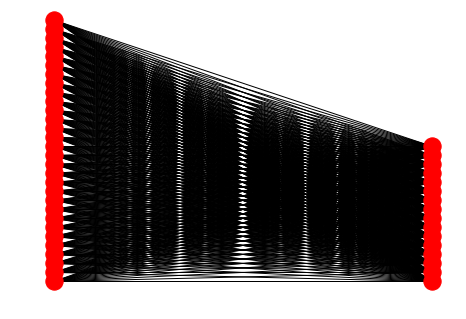

In [24]:
df_pruebas = matching.copy()     

G = create_graph(df_pruebas)
students_list = df_pruebas.index
companies_list = df_pruebas.columns

plot_bipartite_graph(G, students_list, companies_list)

node1, node2, w = get_best_match(G, 'Company ALL MID', [])
node1, node2, w

In [25]:

RONDAS = 15
# print(RONDAS)

print(len(students_list), students_list)

student_queue = list(students_list) * RONDAS # vamos a recorrer la lista para ir emparejando
# print(student_queue)

30 Index(['Miguel Erja González Solís', 'David Redondo Muñoz AKA Hiring Material',
       'Edu Cortada', 'Joan Sánchez Vich', 'Marcos Tagliabue',
       'Llorenç Martinez', 'Miguel Sánchez Díaz', 'Edgar Rosendo Pulido',
       'Ester Fernández Padrós', 'Ivan Quevedo Burgos',
       'Dídac Bigordà Arruego', 'YOSHITSUGU NAGAO', 'Marc Benaiges Torres',
       'Madhur Mata', 'Pablo Grau', 'Tomas Yaya', 'Alejandro Gómez Pernía',
       'Miguel Ribeiro Neto', 'Adriana Perez pinto', 'Pedro Bonilla Miralles',
       'Andreu Camps Corcoll', 'Matías Ferreiro', 'Nicolas Lacaze',
       'Jesús Benages Elena', 'Raúl Delgado Díaz', 'Daniel Téllez Llinás',
       'Francesc Muñoz Gonzalez', 'Ismael Jaouhar Babiano', 'Florencia Dutari',
       'Miguel Angel Moreno Sierra'],
      dtype='object', name='name')


In [26]:
rondas = []

for r in range(RONDAS): 
    aux = []
    used = []
    while len(used) < 2 * len(companies): # ahora used tiene el doble de tamaño. Hay que modificarlo
        student = student_queue.pop(0)
        # print(student)
        node1, node2, w = get_best_match(G, student, used) # creo que se queda sin opciones
        
        # aux.append((node1, node2, w))
        G.remove_edge(node1, node2)
        used.extend([node1, node2])
        
    
        # el nodo1 es la compañía (nodo1 no es estudiante)
        if node1 != student: 
            # used.append(node1)
            aux.append((node1, node2, w))
        # nodo2 es la compañía
        else: 
            # used.append(node2)
            aux.append((node2, node1, w))
        # print(used)
    rondas.append(aux)
        
rondas

[[('Project Lobster', 'Miguel Erja González Solís', 0.30383243470068705),
  ('Ondho', 'David Redondo Muñoz AKA Hiring Material', 0.2857142857142857),
  ('C14TORCE', 'Edu Cortada', 0.27429188517743175),
  ('TALNTD', 'Joan Sánchez Vich', 0.266676643600682),
  ('Amaris', 'Marcos Tagliabue', 0.24257131419419417),
  ('Optimissa Capital Markets', 'Llorenç Martinez', 0.24085413752894708),
  ('Wisestate LTD', 'Miguel Sánchez Díaz', 0.3237998720400827),
  ('Atomian', 'Edgar Rosendo Pulido', 0.3483314773547883),
  ('Farmaconnect', 'Ester Fernández Padrós', 0.3025822873792978),
  ('Bit Genoma Digital Solutions', 'Ivan Quevedo Burgos', 0.23166247903554),
  ('Volcanic Internet', 'Dídac Bigordà Arruego', 0.20197573211702732),
  ('Norwegian', 'YOSHITSUGU NAGAO', 0.1827439976315568),
  ('Abalit Technologies S.L.', 'Marc Benaiges Torres', 0.26049056508156304),
  ('Adidea', 'Madhur Mata', 0.17411239489546831),
  ('BOEHRINGER INGELHEIM ESPAÑA', 'Pablo Grau', 0.17375849795918413),
  ('Movetia', 'Tomas Yay

In [27]:
def check_rondas(rondas): 
    res = []
    for ronda in rondas: 
        companies = [company for company, student, w in ronda]
        students = [student for company, student, w in ronda]
        res.append(len(set(companies)) == len(set(students)) )
    return all(e for e in res)
            
check_rondas(rondas)            

True

In [28]:
def rondas2string(rondas):
    res = ''
    for i, ronda in enumerate(rondas): 
        res += '\n\nRonda {}'.format(i)
        for c, s, w in ronda: 
            res += '\nCompany: {} -> Student: {} -> Matching: {}'.format(c, s, w)
        
    return res
        
        
text = rondas2string(rondas)

with open("Rondas.txt", "w") as f:
    f.write(text)

In [29]:
# beautifultable

table = BeautifulTable()
table.column_headers = ["ronda", "company", "student", "match"]
for i, ronda in enumerate(rondas): 
    for row in ronda: 
        table.append_row([i, row[0], row[1], row[2]])
        
# print(table)

with open("Rondas_table.txt", "w") as f:
    f.write(str(table))

In [30]:
# agrupadas por compañía: 

table = BeautifulTable()
table.column_headers = ["company", "ronda", "student", "match"]

for company in companies_list: 
    for i, ronda in enumerate(rondas): 
        for row in ronda: 
            if row[0] == company: 
                table.append_row([row[0], i, row[1], row[2]])
        
# print(table)

with open("Rondas_table_by_company.txt", "w") as f:
    f.write(str(table))

In [31]:
companies_list

Index(['Movetia', 'Volcanic Internet', 'Farmaconnect', 'C14TORCE', 'Norwegian',
       'Bit Genoma Digital Solutions', 'Atomian', 'Project Lobster',
       'Optimissa Capital Markets', 'Wisestate LTD', 'Adidea',
       'BOEHRINGER INGELHEIM ESPAÑA', 'TALNTD', 'Ondho',
       'Abalit Technologies S.L.', 'Amaris'],
      dtype='object', name='name')

In [32]:

table = BeautifulTable()
table.column_headers = ["student", "company", "ronda", "match"]

for student in students_list: 
    for i, ronda in enumerate(rondas): 
        for row in ronda: 
            if row[1] == student: 
                table.append_row([row[1], row[0], i, row[2]])
'''

'''    
with open("Rondas_table_by_student.txt", "w") as f:
    f.write(str(table))

In [33]:
student_rounds = {}

for student in students_list: 
    total = 0
    for ronda in rondas: 
        for row in ronda: 
            if row[1] == student: 
                total += 1
    student_rounds[student] = total

student_rounds

{'Miguel Erja González Solís': 8,
 'David Redondo Muñoz AKA Hiring Material': 8,
 'Edu Cortada': 8,
 'Joan Sánchez Vich': 8,
 'Marcos Tagliabue': 8,
 'Llorenç Martinez': 8,
 'Miguel Sánchez Díaz': 8,
 'Edgar Rosendo Pulido': 8,
 'Ester Fernández Padrós': 8,
 'Ivan Quevedo Burgos': 8,
 'Dídac Bigordà Arruego': 8,
 'YOSHITSUGU NAGAO': 8,
 'Marc Benaiges Torres': 8,
 'Madhur Mata': 8,
 'Pablo Grau': 8,
 'Tomas Yaya': 8,
 'Alejandro Gómez Pernía': 8,
 'Miguel Ribeiro Neto': 8,
 'Adriana Perez pinto': 8,
 'Pedro Bonilla Miralles': 8,
 'Andreu Camps Corcoll': 8,
 'Matías Ferreiro': 8,
 'Nicolas Lacaze': 8,
 'Jesús Benages Elena': 8,
 'Raúl Delgado Díaz': 8,
 'Daniel Téllez Llinás': 8,
 'Francesc Muñoz Gonzalez': 8,
 'Ismael Jaouhar Babiano': 8,
 'Florencia Dutari': 8,
 'Miguel Angel Moreno Sierra': 8}